# Mini-Project: A Simple Search Engine from Scratch
In this mini-project you will study the fundaments of IR.

The mini-project is divided as follow:

- **Week 1**: Study the provided notebook. Using the VSM retrieval model, run experiments *(section 4)* with the provided collection. Compute the metrics MAP, P10 and precision-recall curves.

- **Week 2**: Implement the LMD and LMJM retrieval models and repeat the experiments with the new models. Compare it to the previous retrieval models.

- **Week 3**: Implement the RM3 retrieval model and repeat the experiments with the new models. Compare it to the previous retrieval models.

- **Week 4**: Implement the BM25 retrieval model and repeat the experiments with the new models. Compare it to the previous retrieval models.

**Submission date: 15 October**

## 1. Vector Space Model

In the vector space model, documents are represented as a vector $d_j=(w_{d_j,1},w_{d_j,2}, ..., w_{d_j,n})$ of $n$ word frequencies -- most of the words are equal to 0. Queries are also represented as a vector of words $q_j=(w_{q_j,1},w_{q_j,2}, ..., w_{q_j,n})$. In the vector space model, each document word is weighted by their *tf-idf*

$${tf-idf} = tf*\frac{|D|}{log (df(w_a))}$$

The vector space model is based on the cosine similarity, which measures the angle between the two vectors in the 1-unit sphere:

$$cos(q,d) = \frac{\sum_t q_t\cdot d_t}{\sqrt{\sum_t q^2_t}\cdot \sqrt{\sum_t d^2_t }}$$


Below you can read the corresponding matricial implementation for multiple documents.

### Parser
Using the CountVectorizer class of Scikit-Learn, try the different parser options by generating unigrams and bigrams with different stop words.


In [31]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', 
                                    min_df=1, stop_words = {'the', 'is'})

corpus = ['This is the first document.',
'This is the second second document.',
'And the third one.',
'Is this the first document?', ]

In [32]:
uni_analyze = vectorizer.build_analyzer()
uni_analyze("This is a text document to analyze.")

['this', 'is', 'text', 'document', 'to', 'analyze']

In [33]:
tf_uni = vectorizer.fit_transform(corpus).toarray()
print(vectorizer.get_feature_names())
print()
print(tf_uni)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

[[0 1 1 1 0 0 1 0 1]
 [0 1 0 1 0 2 1 0 1]
 [1 0 0 0 1 0 1 1 0]
 [0 1 1 1 0 0 1 0 1]]


In [34]:
bi_analyze = bigram_vectorizer.build_analyzer()
bi_analyze("This is a text document to analyze.") 

['this',
 'a',
 'text',
 'document',
 'to',
 'analyze',
 'this a',
 'a text',
 'text document',
 'document to',
 'to analyze']

In [35]:
tf_bi = bigram_vectorizer.fit_transform(corpus).toarray()
print(bigram_vectorizer.get_feature_names())
print()
print(tf_bi)

['and', 'and third', 'document', 'first', 'first document', 'one', 'second', 'second document', 'second second', 'third', 'third one', 'this', 'this first', 'this second']

[[0 0 1 1 1 0 0 0 0 0 0 1 1 0]
 [0 0 1 0 0 0 2 1 1 0 0 1 0 1]
 [1 1 0 0 0 1 0 0 0 1 1 0 0 0]
 [0 0 1 1 1 0 0 0 0 0 0 1 1 0]]


In [36]:
bigram_vectorizer.vocabulary_.get('document')

2

### TF IDF and the cosine similarity

In [38]:
termCollFreq = np.sum(tf_uni != 0, axis = 0)
docLen = np.sum(tf_uni, axis = 1)

idf = np.log(np.size(corpus)/termCollFreq)
idf_rows = np.dot(np.ones((np.size(corpus),1)), idf.reshape(1,np.size(idf)))
tfidf = tf_uni*idf_rows

docNorms = np.sqrt(np.sum(np.power(tfidf,2), axis = 1))
        
print("\ntf:\n", tf_uni)
print("\nidf:\n", idf)
print("\nidf:\n", (idf > 0.3)* idf)
print("\ntfidf:\n", tfidf)
print("\ndocnorms:\n", docNorms)


tf:
 [[0 1 1 1 0 0 1 0 1]
 [0 1 0 1 0 2 1 0 1]
 [1 0 0 0 1 0 1 1 0]
 [0 1 1 1 0 0 1 0 1]]

idf:
 [1.38629436 0.28768207 0.69314718 0.28768207 1.38629436 1.38629436
 0.         1.38629436 0.28768207]

idf:
 [1.38629436 0.         0.69314718 0.         1.38629436 1.38629436
 0.         1.38629436 0.        ]

tfidf:
 [[0.         0.28768207 0.69314718 0.28768207 0.         0.
  0.         0.         0.28768207]
 [0.         0.28768207 0.         0.28768207 0.         2.77258872
  0.         0.         0.28768207]
 [1.38629436 0.         0.         0.         1.38629436 0.
  0.         1.38629436 0.        ]
 [0.         0.28768207 0.69314718 0.28768207 0.         0.
  0.         0.         0.28768207]]

docnorms:
 [0.85366032 2.81700748 2.40113227 0.85366032]


In [39]:
query = 'document'
query_vector = vectorizer.transform([query]).toarray()
queryNorm = np.sqrt(np.sum(np.power(query_vector, 2), axis = 1))

doc_scores = np.dot(query_vector, tfidf.T)/(docNorms*queryNorm)

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


### Inverted Index
The matricial implementation is not scalable because it computes the similarity for all documents in the collection. However, one should only compute the similarity for the documents containing the query words. This is where the inverted index comes to our rescue.

Read the inverted index implementation presented next. Describe in your own words how the cosine similarity should be implemented with the inverted index:


In [9]:
features = vectorizer.get_feature_names()

i = 0
inverted_index = dict()
for token in features:
    print("==== Creating the posting list for token \"", token, "\"")
    docs_with_token = np.where(tf_uni[:,i] != 0)
    len = np.size(docs_with_token,1)
    
    postings_matrix = np.concatenate([tf_uni[docs_with_token,i], docs_with_token])
    postings_list = list(map(tuple, postings_matrix.T))
    inverted_index[token] = postings_list

    print(postings_list)
    i = i + 1

==== Creating the posting list for token " and "
[(1, 2)]
==== Creating the posting list for token " document "
[(1, 0), (1, 1), (1, 3)]
==== Creating the posting list for token " first "
[(1, 0), (1, 3)]
==== Creating the posting list for token " is "
[(1, 0), (1, 1), (1, 3)]
==== Creating the posting list for token " one "
[(1, 2)]
==== Creating the posting list for token " second "
[(2, 1)]
==== Creating the posting list for token " the "
[(1, 0), (1, 1), (1, 2), (1, 3)]
==== Creating the posting list for token " third "
[(1, 2)]
==== Creating the posting list for token " this "
[(1, 0), (1, 1), (1, 3)]


### Evaluation
Using the Vector Space Model, run the experiments of section 4.

We advice you to use an external Python IDE for editing more complex implementations. **The Notebook should be used as a notebook, not as an IDE**. Your implementations should be organized on external classes as below:

In [10]:
import RetrievalModelsMatrix as b

aa = b.RetrievalModelsMatrix(tf_uni, vectorizer)

aa.score_vsm('document')

array([[0.33695882, 0.10211967, 0.        , 0.33695882]])

## 2. Retrieval Models

In this section you will implement three of the most popular retrieval model. After finishing each retrieval model implementation, run the experiments of section 4 with the new model.

### Language Model with Jelineck-Mercer Smoothing (20%)
The family of Language Models for retrieval build on the density distribution of the terms over each document and the density distribution of terms over the collection of documents.

There several ways of avoiding the zero probabilities problem with term smoothing.  The Jelineck-Mercer smoothing model uses a mixture of probabilities between the document model $M_d$ and the corpus model $M_c$:

$$p(q|d,C)= \lambda \cdot p(q|M_d) + (1-\lambda)\cdot p(q|M_c)$$

Implement the LMJM retrieval model using the matricial definitions:

In [11]:
query = "document"

# TO DO: LMJM model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


Implement the LMJM retrieval model using the inverted-index data structures:

In [12]:
query = "document"

# TO DO: LMJM model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


### Language Model with Dirichlet Smoothing (20%)
Another way of avoiding the zero probabilities problem is with the Dirichlet smoothing model that uses a mixture of frequencies between the term document frequencies $f_{t,c}$ and the term corpus frequency $\mu \cdot M_c(t)$:

$$p(t|M_d, M_c)= \frac{f_{t,d}+\mu \cdot M_c(t)}{|d| + \mu}$$

Implement the LMD retrieval model using the matricial definitions:


In [13]:
query = "document"

# TO DO: LMD model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


Implement the LMD retrieval model using the inverted-index data structures:

In [14]:
query = "document"

# TO DO: LMD model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


### BM 25 (20%)

The BM25 is model is an evolution of the tf-idf weighting based on a two Poisson distribution per term. It is obviously impossible to estimate each term distribution -- the approximation to the two Poisson distribution is given by the expression:

$$RSV = \sum q_t \cdot \frac{f_{t,d}(k_1 + 1)}{k_1 ((1-b) + b(\frac{l_d}{l_avg})) + f_{t,d} }\cdot IDF_t$$

Implement the BM5 retrieval model using the matricial definitions:

In [15]:
query = "document"

# TO DO: BM25 model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


Implement the BM25 retrieval model using the inverted-index data structures:

In [16]:
query = "document"

# TO DO: BM25 model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


### Evaluation
Using the implemented Retrieval Models, run the experiments of section 4.


## 3. Pseudo-Relevance Feedback (RM3) (20%)

Using the RM3 Model, run the experiments of section 4.

Implement the RM3 retrieval model using the matricial definitions:

In [17]:
query = "document"

# TO DO: RM3 model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


Implement the RM3 retrieval model using the inverted-index data structures:

In [18]:
query = "document"

# TO DO: RM3 model

print(doc_scores)

[[0.3369983  0.10212329 0.         0.3369983 ]]


### Evaluation
Using the implemented RM3 model, run the experiments of section 4.


## 4. Experiments and Results (20%)
The goal of this section is to compare experimentally the different retrieval models. In this section you must:
- Load the Cranfield documents.
- Run the implemented retrieval models
- Plot the precision-recall curves.
- Compute MAP.

In [44]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import simpleparser as parser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import collectionloaders
import RetrievalModelsMatrix as models

verbose = True
bigrams = True

### 1. Load the corpus
cranfield = collectionloaders.CranfieldTestBed()

### 2. Parse the corpus
# Tokenize, stem and remove stop words
if not bigrams:
    vectorizer = CountVectorizer()
else:
    vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', 
                                    min_df=1, stop_words = {'the', 'is'})

corpus = parser.stemCorpus(cranfield.corpus_cranfield['abstract'])

### 3. Create the model
# Compute the term frequencies matrix and the model statistics
tf_cranfield = vectorizer.fit_transform(corpus).toarray()
models = models.RetrievalModelsMatrix(tf_cranfield, vectorizer)

### 4. Run the queries over the corpus
i = 1
map_vsm = 0
precision_vsm = []
precision_average = []

for query in cranfield.queries:
    # Parse the query and compute the document scores
    scores = models.score_vsm(parser.stemSentence(query))

    # Do the evaluation
    [average_precision, precision, recall, thresholds] = cranfield.eval(scores, i)
    map_vsm = map_vsm + average_precision
    precision_vsm.append(precision)
    precision_average[i] = average_precision
    
    # Some messages...
    if verbose:
        plt.plot(recall, precision, color='silver', alpha=0.1)
        print('qid =',i, 'VSM     AP=',average_precision)
        
    i = i + 1

map_vsm = map_vsm/cranfield.num_queries
print('\nmap_vsm',map_vsm)
print('\n', precision_average < 0.001)


Number of documents:  1400
Number of queries:  225


IndexError: list assignment index out of range

In [23]:
cranfield.queries

0      what similarity laws must be obeyed when const...
1      what are the structural and aeroelastic proble...
2      what problems of heat conduction in composite ...
3      can a criterion be developed to show empirical...
4      what chemical kinetic system is applicable to ...
5      what theoretical and experimental guides do we...
6      is it possible to relate the available pressur...
7      what methods -dash exact or approximate -dash ...
8      papers on internal /slip flow/ heat transfer s...
9      are real-gas transport properties for air avai...
10     is it possible to find an analytical,  similar...
11     how can the aerodynamic performance of channel...
12     what is the basic mechanism of the transonic a...
13             papers on shock-sound wave interaction . 
14      material properties of photoelastic materials . 
15     can the transverse potential flow about a body...
16     can the three-dimensional problem of a transve...
17     are experimental pressur

MAP= 0.2842886435106585


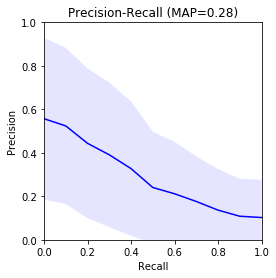

In [24]:
### Show results
print('MAP=',map_vsm)

mean_precision = np.mean(precision_vsm,axis=0)
std_precision = np.std(precision_vsm,axis=0)

plt.plot(recall, np.mean(precision_vsm,axis=0), color='b', alpha=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.fill_between(recall, 
                 mean_precision - std_precision, 
                 mean_precision + std_precision, facecolor='b', alpha=0.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall (MAP={0:0.2f})'.format(map_vsm))
plt.savefig('results/prec-recall.png', dpi=100)


### Results and discussion


The following table summarizes the MAP and P10 results:

| Retrieval Model | P10 | MAP   |
|-----------------|-----|-------|
| VSM             | ?   | {{map_vsm}} |
| LMD             | ?   | ? |
| LMJM             | ?   | ? |
| BM25             | ?   | ? |

![](results/prec-recall.png)